In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pprint import pprint
import pickle
import random

# Helper Functions

In [2]:
def to_percent(y, position):
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

In [3]:
def fmtcols(mylist, cols):
    maxwidth = max(map(lambda x: len(x), mylist))
    justifyList = list(map(lambda x: x.ljust(maxwidth), mylist))
    lines = (' & '.join(justifyList[i:i+cols]) for i in range(0,len(justifyList),cols))
    return " \\\ \n".join(lines)

In [4]:
def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [5]:
def print_latex_tables(cols, k=500):
    formatted = "\\begin{center}\n\\begin{tabular}{|l|l|l|l|}"
    formatted += fmtcols(function_freq.index[-k:], cols)
    formatted += "\n\\end{tabular}\n\\end{center}"
    with open(f"/data/rali7/Tmp/solimanz/data_viz/bottom_{k}.txt", "w") as f:
        f.write(formatted)
        

In [6]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('dark'))

In [81]:
df.to_pickle("/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_transformed.pkl")

In [7]:
df = pd.read_pickle("/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_transformed.pkl")

# Initial Cleaning

In [6]:
df["transformed"] = df.function.str.lower()

In [9]:
# Remove URLs and/or emails from job titles
pattrn = re.compile(r"[\S]+\.(ca|com|org|fr|gov|net)")
df["transformed"] = df["transformed"].str.replace(pattrn, "")

# Replace .NET by dotnet to eliminate complications when removing periods
df["transformed"] = df["transformed"].str.replace(".net\b", "dotnet")

# Replace periods between word by a space
pattrn = re.compile(r"\.(?=[\w]{2})")
df["transformed"] = df["transformed"].str.replace(pattrn, " ")

# Replace periods in acronyms by empty string
df["transformed"] = df["transformed"].str.replace(".", "")

# Remove parens character
df["transformed"] = df["transformed"].str.replace(re.compile(r"\(.*\)"), "")

df["transformed"] = df["transformed"].str.replace(re.compile(r"co(?!\w)(\s)*-?(\s)*"), "co ")
df["transformed"] = df["transformed"].str.replace(re.compile(r"\bcofounder\b"), "co founder")
df["transformed"] = df["transformed"].str.replace(re.compile(r"\bcoowner\b"), "co owner")

#df["transformed"] = df["transformed"].str.replace(re.compile(r"co(?!\w)(\s)*-?(\s)*"), "co_")

# Regular Expressions

In [10]:
transforms = [    
    # senior/junior
    (re.compile(r'\bsr\b'), 'senior'),
    (re.compile(r'\bjr\b'), 'junior'),
    # IT
    (re.compile(r'\bit\b'), 'information technology'),
    # C*O
    (re.compile(r'\bceo\b'), 'chief executive officer'),
    (re.compile(r'\bcoo\b'), 'chief operating officer'),
    (re.compile(r'\bcto\b'), 'chief technology officer'),
    (re.compile(r'\bcfo\b'), 'chief finance officer'),
    (re.compile(r'\bchief financial officer\b'), 'chief finance officer'),
    (re.compile(r'\bchief operations officer\b'), 'chief operating officer'),
    # VP
    (re.compile(r'\bvp\b'), 'vice president'),
    (re.compile(r'\bvice-president\b'), 'vice president'),
    #technician vs tech
    (re.compile(r'\btech\b'), 'technician'),
    #coop
    (re.compile(r'\bco[-|\s]op\b'), 'coop'),
    #addon
    (re.compile(r'\badd[-|\s]on\b'), 'addon'),
    # Nurses
    (re.compile(r'\brn\b'), 'registered nurse'),
    (re.compile(r'\brpn\b'), 'registered practical nurse'),
    #T.A.
    (re.compile(r"\bta\b"), "teaching assistant"),
    (re.compile(r"\bteacher assistant\b"), "teaching assistant"),
    (re.compile(r"\bteacher's assistant\b"), "teaching assistant"),
    (re.compile(r"\bteacher's assitant\b"), "teaching assistant"),
    
    (re.compile(r"\bra\b"), "research assistant"),
    # HR
    (re.compile(r'\bhr\b'), 'human resources'),
    # Customer service reps
    (re.compile(r'\bcsr\b'), 'customer service representative'),
    # qa / qc
    (re.compile(r'\bqa\b'), 'quality assurance'),
    (re.compile(r'\bqc\b'), 'quality control'),
    # database administrator
    (re.compile(r'\bdba\b'), 'database administrator'),
    (re.compile(r'\bdatabase admin\b'), 'database administrator'),
    (re.compile(r'\bdb admin\b'), 'database administrator'),
    # financial service representative
    (re.compile(r'\bfsr\b'), 'financial service representative'),
    # Misspellings
    (re.compile(r'\bfreelance\b'), 'freelancer'),
    (re.compile(r'\bdesiginer\b'), 'designer'),
    (re.compile(r'\bbiomed\b'), 'biomedical'),
    (re.compile(r'\bgoverenment\b'), 'government'),
    (re.compile(r'\bmachanic\b'), 'mechanic'),
    (re.compile(r'\bbusiness owner\b'), 'owner'),
    (re.compile(r'\br(\s)*&(\s)*d\b'), 'research development'),
    (re.compile(r'\br and d\b'), 'research development'),
    (re.compile(r'research/development'), 'research development'),
    (re.compile(r'\beditor-in-chief\b'), 'editor_in_chief'),
    #eit => engineer in training
    (re.compile(r'\beit\b'), 'engineer in training'),
    #ESL
    (re.compile(r'\besl$'), 'english as a second language instructor'),
    (re.compile(r'\besl instructor\b'), 'english as a second language instructor'),
    (re.compile(r'\besl teacher\b'), 'english as a second language instructor'),
    (re.compile(r'\benglish as a second language^'), 'english as a second language instructor'),
    (re.compile(r'\benglish as a second language teacher\b'), 'english as a second language instructor'),
    (re.compile(r'\besl instructor\b'), 'english as a second language instructor'),
    
    (re.compile(r"\binternship\b"), "intern"),
    (re.compile(r"\bsummer intern\b"), "intern"),
    
    (re.compile(r"\bis\b"), "information systems"),
    (re.compile(r"\bgis\b"), "geographic information system"),
    (re.compile(r"\bpr\b"), "public relations"),
    (re.compile(r"\badmin\b"), "administrator"),
    (re.compile(r"\brep\b"), "representative")
]

substitutions = {r: rep for r, rep in transforms}

In [11]:
df['transformed'].replace(substitutions, regex=True, inplace=True)

In [12]:
df['transformed'].replace({re.compile(r"\s{2,}"): " "}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

# Statistics

In [13]:
function_freq = df.transformed.value_counts(normalize=False)

In [12]:
len(function_freq)

3984037

In [19]:
pattrn = re.compile(r"[^a-zA-Z\d\s]")
titles = [set(word_tokenize(re.sub(pattrn, " ", t))) for t in function_freq.index]

In [120]:
zero_length = [i for i, tok in enumerate(titles) if len(tok) == 0]
one_length = [i for i, tok in enumerate(titles) if len(tok) == 1]

In [141]:
weird = [function_freq.index[i] for i in zero_length]

In [132]:
with open("/data/rali7/Tmp/solimanz/data/na_funcs.pkl", "wb") as f:
    pickle.dump(weird, f)

In [29]:
bad_ids = df[df.transformed.isin(weird)]._id.unique()
df = df.drop(df[df._id.isin(bad_ids)].index)

In [68]:
matches = [s for s in function_freq.index if " et " in s or " de " in s]
french_ids = df[df.transformed.isin(matches)]._id.unique()
df = df.drop(df[df._id.isin(french_ids)].index)

In [4]:
function_freq = df.transformed.value_counts(normalize=False)
len(function_freq)

3906306

In [5]:
n_ids = df._id.nunique()
print(n_ids)

2811973


In [6]:
x = list(range(len(function_freq)))

In [14]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 100

#ax = sns.barplot(x=x[:10000], y=function_freq.index[:10000], log=True)
#for ind, label in enumerate(ax.get_xticklabels()):
#    if ind % 100 == 0:
#        label.set_visible(True)
#    else:
#        label.set_visible(False)
        
#ax = sns.distplot(function_freq.values, kde=False, rug=False, hist_kws={"log": True})
#ax.set_title("Distribution of Unique Job Title String Counts")
#t = ax.set_xlabel("String Counts")

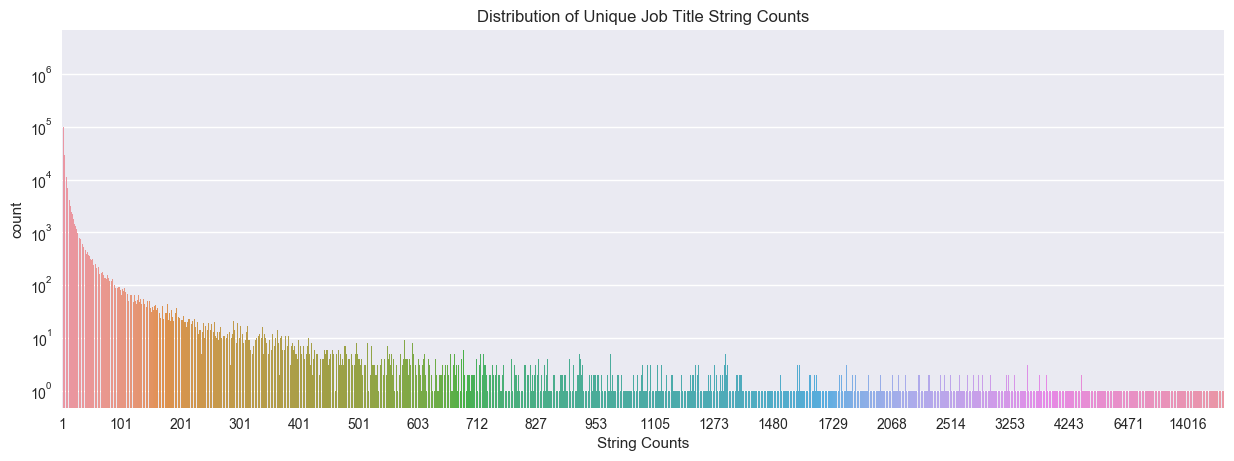

In [164]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 100

ax = sns.countplot(function_freq.values, log=True)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 100 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
#ax = sns.distplot(function_freq.values, kde=False, rug=False, hist_kws={"log": True})
ax.set_title("Distribution of Unique Job Title String Counts")
t = ax.set_xlabel("String Counts")

In [19]:
cc = Counter(function_freq.values)
sum([x[1] for x in cc.most_common(10)])/len(function_freq)

0.9817820211729444

client service representative, hazardous waste **informationdotnetwork**

In [28]:
bottom = function_freq.index.values[-1000:]

In [82]:
random.sample(list(bottom), 100)

In [69]:
print_latex_tables(3)

## Job Title Strings N-grams

In [42]:
# Tokenize job title strings
pattrn = re.compile(r"[^a-zA-Z\d\s]")
joined = " ".join(function_freq.index.values)
joined = re.sub(pattrn, " ", joined)
tokens = word_tokenize(joined)
to_remove = set(stopwords.words('english'))
tokens = list(filter(lambda s: s not in to_remove, tokens))

In [43]:
unigram_counts = Counter(tokens)

In [44]:
t = []
for tok, count in unigram_counts.items():
    if len(tok) > 1 and len(tok) < 4:
        t.append((tok, count))

In [45]:
pattrn = re.compile(r"[^a-zA-Z\d\s]")
titles = [set(word_tokenize(re.sub(pattrn, " ", t))) for t in function_freq.index]

In [46]:
num_toks_title = [len(toks) for toks in titles]

Text(0.5,0,'String Length')

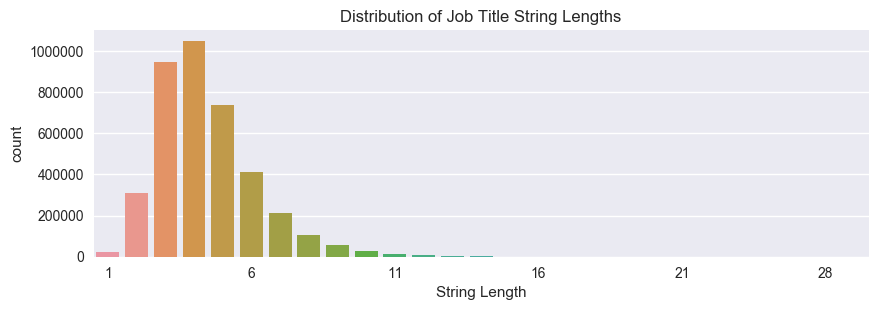

In [134]:
plt.rcParams['figure.figsize'] = 10, 3
plt.rcParams['figure.dpi'] = 100

ax = sns.countplot(num_toks_title)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

ax.set_title("Distribution of Job Title String Lengths")
ax.set_xlabel("String Length")

Text(0.5,0,'Number of Tokens')

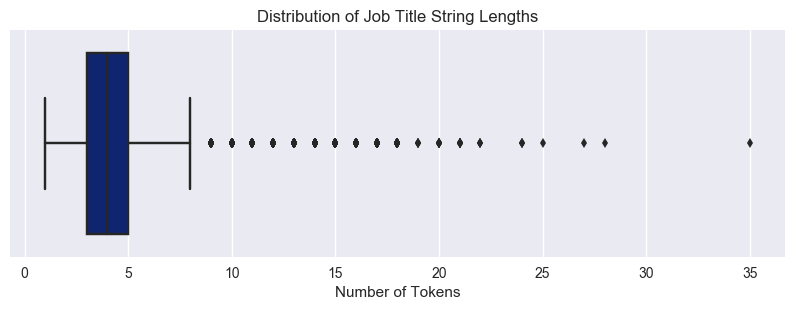

In [47]:
plt.rcParams['figure.figsize'] = 10, 3
plt.rcParams['figure.dpi'] = 100
ax = sns.boxplot(num_toks_title, orient='h')
ax.set_title("Distribution of Job Title String Lengths")
ax.set_xlabel("Number of Tokens")

In [143]:
unigrams = sorted(unigram_counts.keys(), key=lambda k: unigram_counts[k], reverse=True)
avgs = []
top_ks = np.arange(10, len(unigrams), 100)

for k in top_ks:
    to_keep = set(unigrams[:k])
    n_tokens = np.zeros(len(function_freq), dtype=np.int32)
    
    for i, title in enumerate(titles):
        n_tokens[i] = len(title.intersection(to_keep))
    
    avgs.append(np.average(n_tokens))

In [144]:
with open("/data/rali7/Tmp/solimanz/data/top_ks.pkl", "wb") as f:
    pickle.dump(file=f, obj=top_ks)
with open("/data/rali7/Tmp/solimanz/data/avgs.pkl", "wb") as f:
    pickle.dump(file=f, obj=avgs)

In [48]:
with open("/data/rali7/Tmp/solimanz/data/top_ks.pkl", "rb") as f:
    top_ks = pickle.load(file=f)
with open("/data/rali7/Tmp/solimanz/data/avgs.pkl", "rb") as f:
    avgs = pickle.load(file=f)

In [76]:
top_ks[18]

1810

In [75]:
for i, v in enumerate(avgs):
    if v >= 3.5:
        print(i)
        break

18


Text(0,0.5,'Avg. # of tokens (length)')

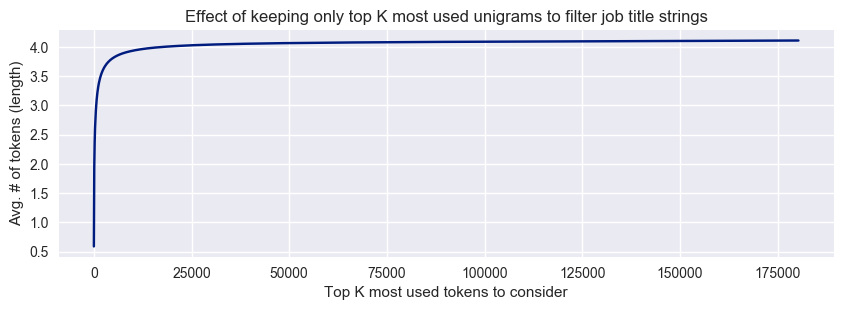

In [157]:
plt.rcParams['figure.figsize'] = 10, 3
plt.rcParams['figure.dpi'] = 100

plt.plot(top_ks, avgs)
plt.title("Effect of keeping only top K most used unigrams to filter job title strings")
plt.xlabel("Top K most used tokens to consider")
plt.ylabel("Avg. # of tokens (length)")

In [14]:
bigrams = get_ngrams(2, tokens)
trigrams = get_ngrams(3, tokens)
fourgrams = get_ngrams(4, tokens)
fivegrams = get_ngrams(5, tokens)

In [15]:
unigram_counts = Counter(tokens)
bigrams_counts = Counter(bigrams)
trigrams_counts = Counter(trigrams)
fourgrams_counts = Counter(fourgrams)
fivegrams_counts = Counter(fivegrams)

In [20]:
fivegrams_counts.most_common(10)

[(('english', 'second', 'language', 'instructor', 'instructor'), 3591),
 (('second', 'language', 'instructor', 'instructor', 'teacher'), 934),
 (('second', 'language', 'instructor', 'instructor', 'instructor'), 649),
 (('executive', 'assistant', 'chief', 'executive', 'officer'), 534),
 (('assistant', 'president', 'chief', 'executive', 'officer'), 303),
 (('chief', 'finance', 'officer', 'vice', 'president'), 287),
 (('quality', 'assurance', 'quality', 'control', 'inspector'), 250),
 (('executive', 'assistant', 'senior', 'vice', 'president'), 231),
 (('vice', 'president', 'chief', 'finance', 'officer'), 226),
 (('executive', 'assistant', 'president', 'chief', 'executive'), 205)]

In [ ]:
counts = list(filter(lambda x: x > 0, token_counts.values()))

In [ ]:
avg = sum(counts)/len(counts)

In [ ]:
keywords = list(filter(lambda x: token_counts[x] > avg, token_counts.keys()))

In [ ]:
plt.rcParams['figure.figsize'] = 15, 7
plt.rcParams['figure.dpi'] = 100

ax = sns.distplot(counts, kde=False, rug=False, hist_kws={"log": True})
ax.set_title("Distribution of Unique Token Counts")
ax.set_xlabel("Token Counts")

In [ ]:
n_tokens = len(token_counts.keys())
n_titles = len(function_freq)
print(f"Number of Unique Tokens: {n_tokens}\nNumber of Unique Job Title Stings: {n_titles}")

In [ ]:
count_mapping = defaultdict(list)
for tok, count in token_counts.items():
        count_mapping[count].append(tok)

In [ ]:
count_ntok = sorted([(k, len(v)) for k, v in count_mapping.items()], key=lambda i: i[0] )

In [ ]:
counts = [x[0] for x in count_ntok]
num_tok = [x[1] for x in count_ntok]

In [ ]:
avg_title_len = sum([len(s) for s in function_freq.index.values])/len(function_freq)

In [ ]:
print(f"Average title length: {avg_title_len}")
print(f"Maximum length: {max(title_lenghts)}")

In [ ]:
title_lenghts = np.array([len(s) for s in function_freq.index.values])

In [ ]:
matches =  [s for s in function_freq.index if "geographic information system" in s]

In [ ]:
matches

In [77]:
keywords = [t[0] for t in unigram_counts.most_common(1810)]

In [78]:
keywords = set(keywords)
pttrn = re.compile(r"[^a-zA-Z\d\s]")
def clean(s):
    r = re.sub(pttrn, " ", s)
    tokens = word_tokenize(s)
    return " ".join(filter(lambda t: t if t in keywords else '', tokens))

In [79]:
reduced = df["transformed"].apply(clean)

In [ ]:
clean("server/bartender bar, bar cart")

In [57]:
df["reduced_titles"] = reduced

In [ ]:
with open("/data/rali7/Tmp/solimanz/data/datasets/reduced.pkl", "rb")as f:
    reduced = pickle.load(f)

In [73]:
reduced_funcs = reduced.value_counts()

In [74]:
len(reduced_funcs)

3045359

In [84]:
avg_count = sum(function_freq.values)/len(function_freq)

In [87]:
len(function_freq[function_freq > avg_count])

212931

In [94]:
avgs = []
iterations = []
avg = 0
fs = function_freq
for i in range(100):
    fs = fs[fs > avg]    
    if len(fs) == 0:
        break
        
    avg = sum(fs.values)/len(fs)
    avgs.append(avg)
    iterations.append(i)

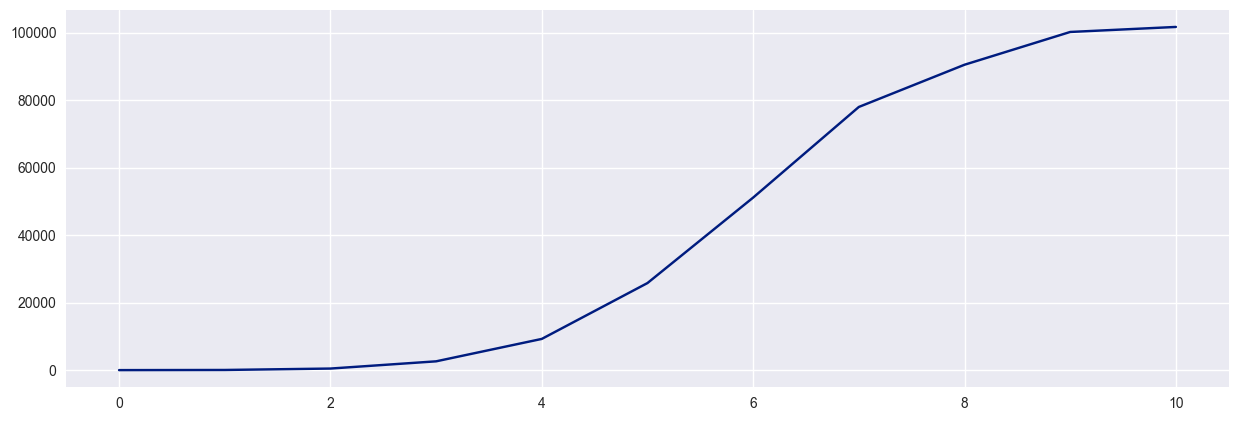

In [96]:
plt.plot(iterations, avgs)

In [118]:
all_ids = df._id.unique()
top_ks = np.arange(10, 600000, 100)

In [ ]:
n_examples = []
for k in top_ks:
    to_remove = df[~df.transformed.isin(function_freq.index[:k])]._id.unique()
    n_examples.append(len(all_ids) - len(to_remove))

In [ ]:
with open("/data/rali7/Tmp/solimanz/data/pickles/n_ex.pkl", "wb") as f:
    pickle.dump(file=f, obj=n_examples)

In [122]:
ratios = [n_titles/n_ex for n_titles, n_ex in zip(top_ks, n_examples)]

In [129]:
gains = [(100*(b - a))/a for a, b in zip(n_examples[:-1], n_examples[1:])]

In [132]:
tk = top_ks[1:]

Text(0,0.5,'Gain of training examples')

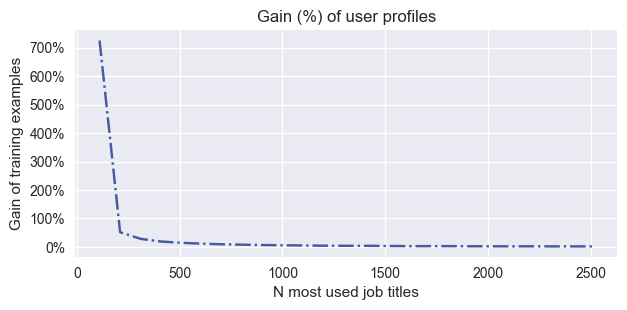

In [191]:
plt.rcParams['figure.figsize'] = 7, 3
plt.rcParams['figure.dpi'] = 100

plt.plot(tk[:25], gains[:25], '-.', alpha=0.7)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.title("Gain (%) of user profiles")
plt.xlabel("N most used job titles")
plt.ylabel("Gain of training examples")